In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
import pandas as pd

def fix_gotoes_header(filepath):
    """
    Corrige les CSV Garmin exportés avec un header décalé (colonne 'GOTOES_CSV').
    → Décale tous les noms de colonnes d’un cran vers la gauche.
    """
    # Lecture brute du CSV
    df = pd.read_csv(filepath, header=0)
    
    # Vérifie si le premier header est 'GOTOES_CSV'
    if df.columns[0] == 'GOTOES_CSV':
        print(f"⚙️ Correction du header 'GOTOES_CSV' dans {filepath.split('\\')[-1]}")

        # Décale les noms de colonnes d’un cran vers la gauche
        new_cols = df.columns[1:].tolist() + ['extra_col']
        df.columns = new_cols
    
    return df


In [4]:
# Charger un seul fichier corrigé
marathon1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_1.csv")
marathon2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_2.csv")
semi1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_1.csv")
semi2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_2.csv")
semi3 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_3.csv")
dix1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\10k_1.csv")
dix2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\10k_2.csv")
# Vérifie le résultat
print("✅ Nouvelles colonnes :", marathon1.columns[:10].tolist())

⚙️ Correction du header 'GOTOES_CSV' dans marathon_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans marathon_2.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_2.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_2.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_3.csv
⚙️ Correction du header 'GOTOES_CSV' dans 10k_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans 10k_2.csv
✅ Nouvelles colonnes : ['timestamp', 'position_lat', 'position_long', 'altitude', 'heart_rate', 'cadence', 'distance', 'speed', 'power', 'compressed_speed_distance']
⚙️ Correction du header 'GOTOES_CSV' dans semi_3.csv
⚙️ Correction du header 'GOTOES_CSV' dans 10k_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans 10k_2.csv
✅ Nouvelles colonnes : ['timestamp', 'position_lat', 'position_long', 'altitude', 'heart_rate', 'cadence', 'distance', 'speed', 'power', 'compressed_speed_distance']


In [5]:
courses = {
    "Marathon 1": marathon1,
    "Marathon 2": marathon2,
    "Semi 1": semi1,
    "Semi 2": semi2,
    "Semi 3": semi3,
    "10 km 1": dix1,
    "10 km 2": dix2
}

In [6]:
# Colonnes d'intérêt
cols = ['distance', 'timestamp', 'stance_time', 'vertical_oscillation', 'step_length', 'enhanced_speed', 'heart_rate', 'enhanced_altitude']



In [6]:
marathon1['enhanced_altitude'].value_counts()

enhanced_altitude
214.4    166
215.0    142
215.2    135
214.6    123
214.2    121
        ... 
294.4      1
289.4      1
290.0      1
288.2      1
288.6      1
Name: count, Length: 568, dtype: int64

In [12]:
# ======================================
# ⚙️ 1. Préparation et vérification des données
# ======================================
def prepare_course(df, course_name):
    """
    Nettoie et prépare les données Garmin avec les bonnes unités :
      - Supprime les lignes invalides
      - Convertit les colonnes en unités cohérentes
      - Filtre les valeurs aberrantes
    """
    # Colonnes attendues
    cols = ['distance', 'timestamp', 'stance_time', 'vertical_oscillation', 'step_length',
            'enhanced_speed', 'heart_rate', 'enhanced_altitude']

    # Vérification de la présence des colonnes
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"❌ Colonnes manquantes dans {course_name}: {missing}")

    # Copie et sélection des colonnes
    df = df[cols].copy()

    # Suppression des lignes vides
    df = df.dropna()

    # ✅ Suppression des valeurs aberrantes sur le temps de contact au sol
    df = df[df['stance_time'] <= 1500]

    # ✅ Conversion des unités (corrigé selon tes précisions)
    # vertical_oscillation : divisé par 10 → passe en centimètres
    df['vertical_oscillation'] = df['vertical_oscillation'] / 10.0

    # step_length : divisé par 1000 → passe en mètres
    df['step_length'] = df['step_length'] / 1000.0

    # ✅ Suppression des vitesses nulles ou aberrantes
    df = df[df['enhanced_speed'] > 0]

    # Affichage optionnel pour suivi
    print(f"✅ {course_name} : {len(df)} lignes valides après nettoyage")

    return df


# Exemple de préparation sur une course
marathon1_clean = prepare_course(marathon1, "Marathon 1")

✅ Marathon 1 : 12131 lignes valides après nettoyage


In [13]:
def describe_biomechanics(df, course_name):
    stats = df[['enhanced_speed', 'heart_rate', 'stance_time',
                'vertical_oscillation', 'step_length']].describe().T.round(3)
    print(f"\n📊 Statistiques descriptives — {course_name}")
    print(stats)
    return stats

# Exemple
describe_biomechanics(marathon1_clean, "Marathon 1")



📊 Statistiques descriptives — Marathon 1
                        count     mean    std      min      25%      50%  \
enhanced_speed        12131.0   12.521  1.139    5.778   11.923   12.528   
heart_rate            12131.0  142.145  5.016   69.000  140.000  143.000   
stance_time           12131.0  240.030  9.931  202.000  235.000  239.000   
vertical_oscillation  12131.0    9.506  0.400    4.100    9.240    9.500   
step_length           12131.0    1.188  0.102    0.418    1.132    1.188   

                          75%      max  
enhanced_speed         13.201   17.600  
heart_rate            145.000  150.000  
stance_time           245.000  309.000  
vertical_oscillation    9.770   11.850  
step_length             1.248    1.746  


,count,mean,std,min,25%,50%,75%,max
enhanced_speed,12131.0,12.521,1.139,5.778,11.923,12.528,13.201,17.600
heart_rate,12131.0,142.145,5.016,69.000,140.000,143.000,145.000,150.000
stance_time,12131.0,240.030,9.931,202.000,235.000,239.000,245.000,309.000
vertical_oscillation,12131.0,9.506,0.400,4.100,9.240,9.500,9.770,11.850
step_length,12131.0,1.188,0.102,0.418,1.132,1.188,1.248,1.746


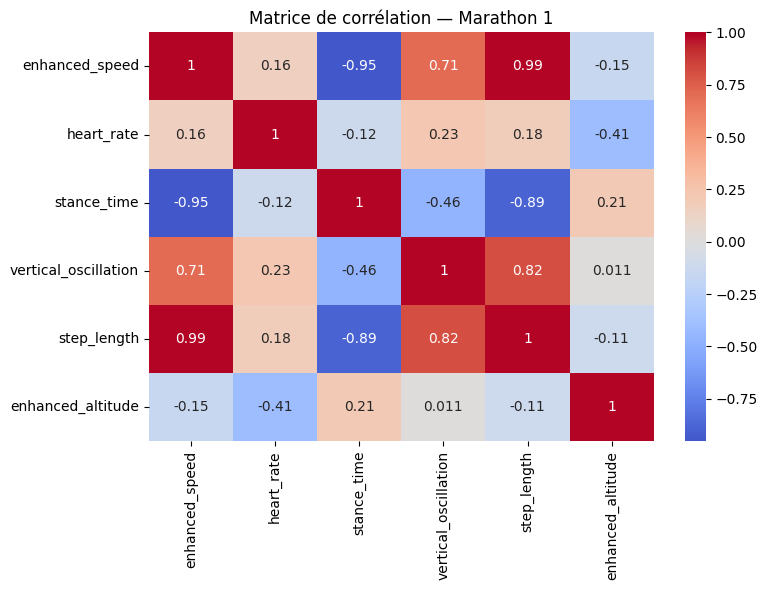


✅ Corrélations principales (Marathon 1):
  ➕ step_length ↔ speed : 0.985
  ➖ stance_time ↔ speed : -0.953
  ➖ altitude ↔ speed    : -0.148
  ➕ heart_rate ↔ altitude : -0.409


In [14]:
def plot_correlations(df, course_name):
    corr = df[['enhanced_speed', 'heart_rate', 'stance_time',
               'vertical_oscillation', 'step_length', 'enhanced_altitude']].corr()
    
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title(f"Matrice de corrélation — {course_name}")
    plt.tight_layout()
    plt.show()

    print(f"\n✅ Corrélations principales ({course_name}):")
    print(f"  ➕ step_length ↔ speed : {corr.loc['step_length','enhanced_speed']:.3f}")
    print(f"  ➖ stance_time ↔ speed : {corr.loc['stance_time','enhanced_speed']:.3f}")
    print(f"  ➖ altitude ↔ speed    : {corr.loc['enhanced_altitude','enhanced_speed']:.3f}")
    print(f"  ➕ heart_rate ↔ altitude : {corr.loc['heart_rate','enhanced_altitude']:.3f}")

# Exemple
plot_correlations(marathon1_clean, "Marathon 1")


# 📊 Analyse Approfondie de la Biomécanique de Course

Dans cette section, nous allons réaliser plusieurs analyses avancées :
1. Évolution temporelle des paramètres clés
2. Détection des zones d'effort et récupération
3. Analyse des cycles de foulée
4. Prévisions pour les performances futures

In [25]:
def prepare_time_series(df):
    """
    Prépare les séries temporelles pour l'analyse avec un index temporel
    """
    # Conversion du timestamp en datetime
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    # Calcul des variables dérivées
    df['pace'] = 60 / df['enhanced_speed']  # min/km (vitesse déjà en km/h)
    df['stride_frequency'] = (df['enhanced_speed'] * 1000/3600) / df['step_length']  # pas/seconde
    
    return df

# Préparation des données pour toutes les courses
time_series = {}
for name, course in courses.items():
    clean_course = prepare_course(course, name)
    time_series[name] = prepare_time_series(clean_course)

print("✅ Séries temporelles préparées pour toutes les courses")

✅ Marathon 1 : 12131 lignes valides après nettoyage
✅ Marathon 2 : 11408 lignes valides après nettoyage
✅ Semi 1 : 5635 lignes valides après nettoyage
✅ Semi 2 : 5636 lignes valides après nettoyage
✅ Semi 3 : 5187 lignes valides après nettoyage
✅ 10 km 1 : 3022 lignes valides après nettoyage
✅ 10 km 2 : 2732 lignes valides après nettoyage
✅ Séries temporelles préparées pour toutes les courses


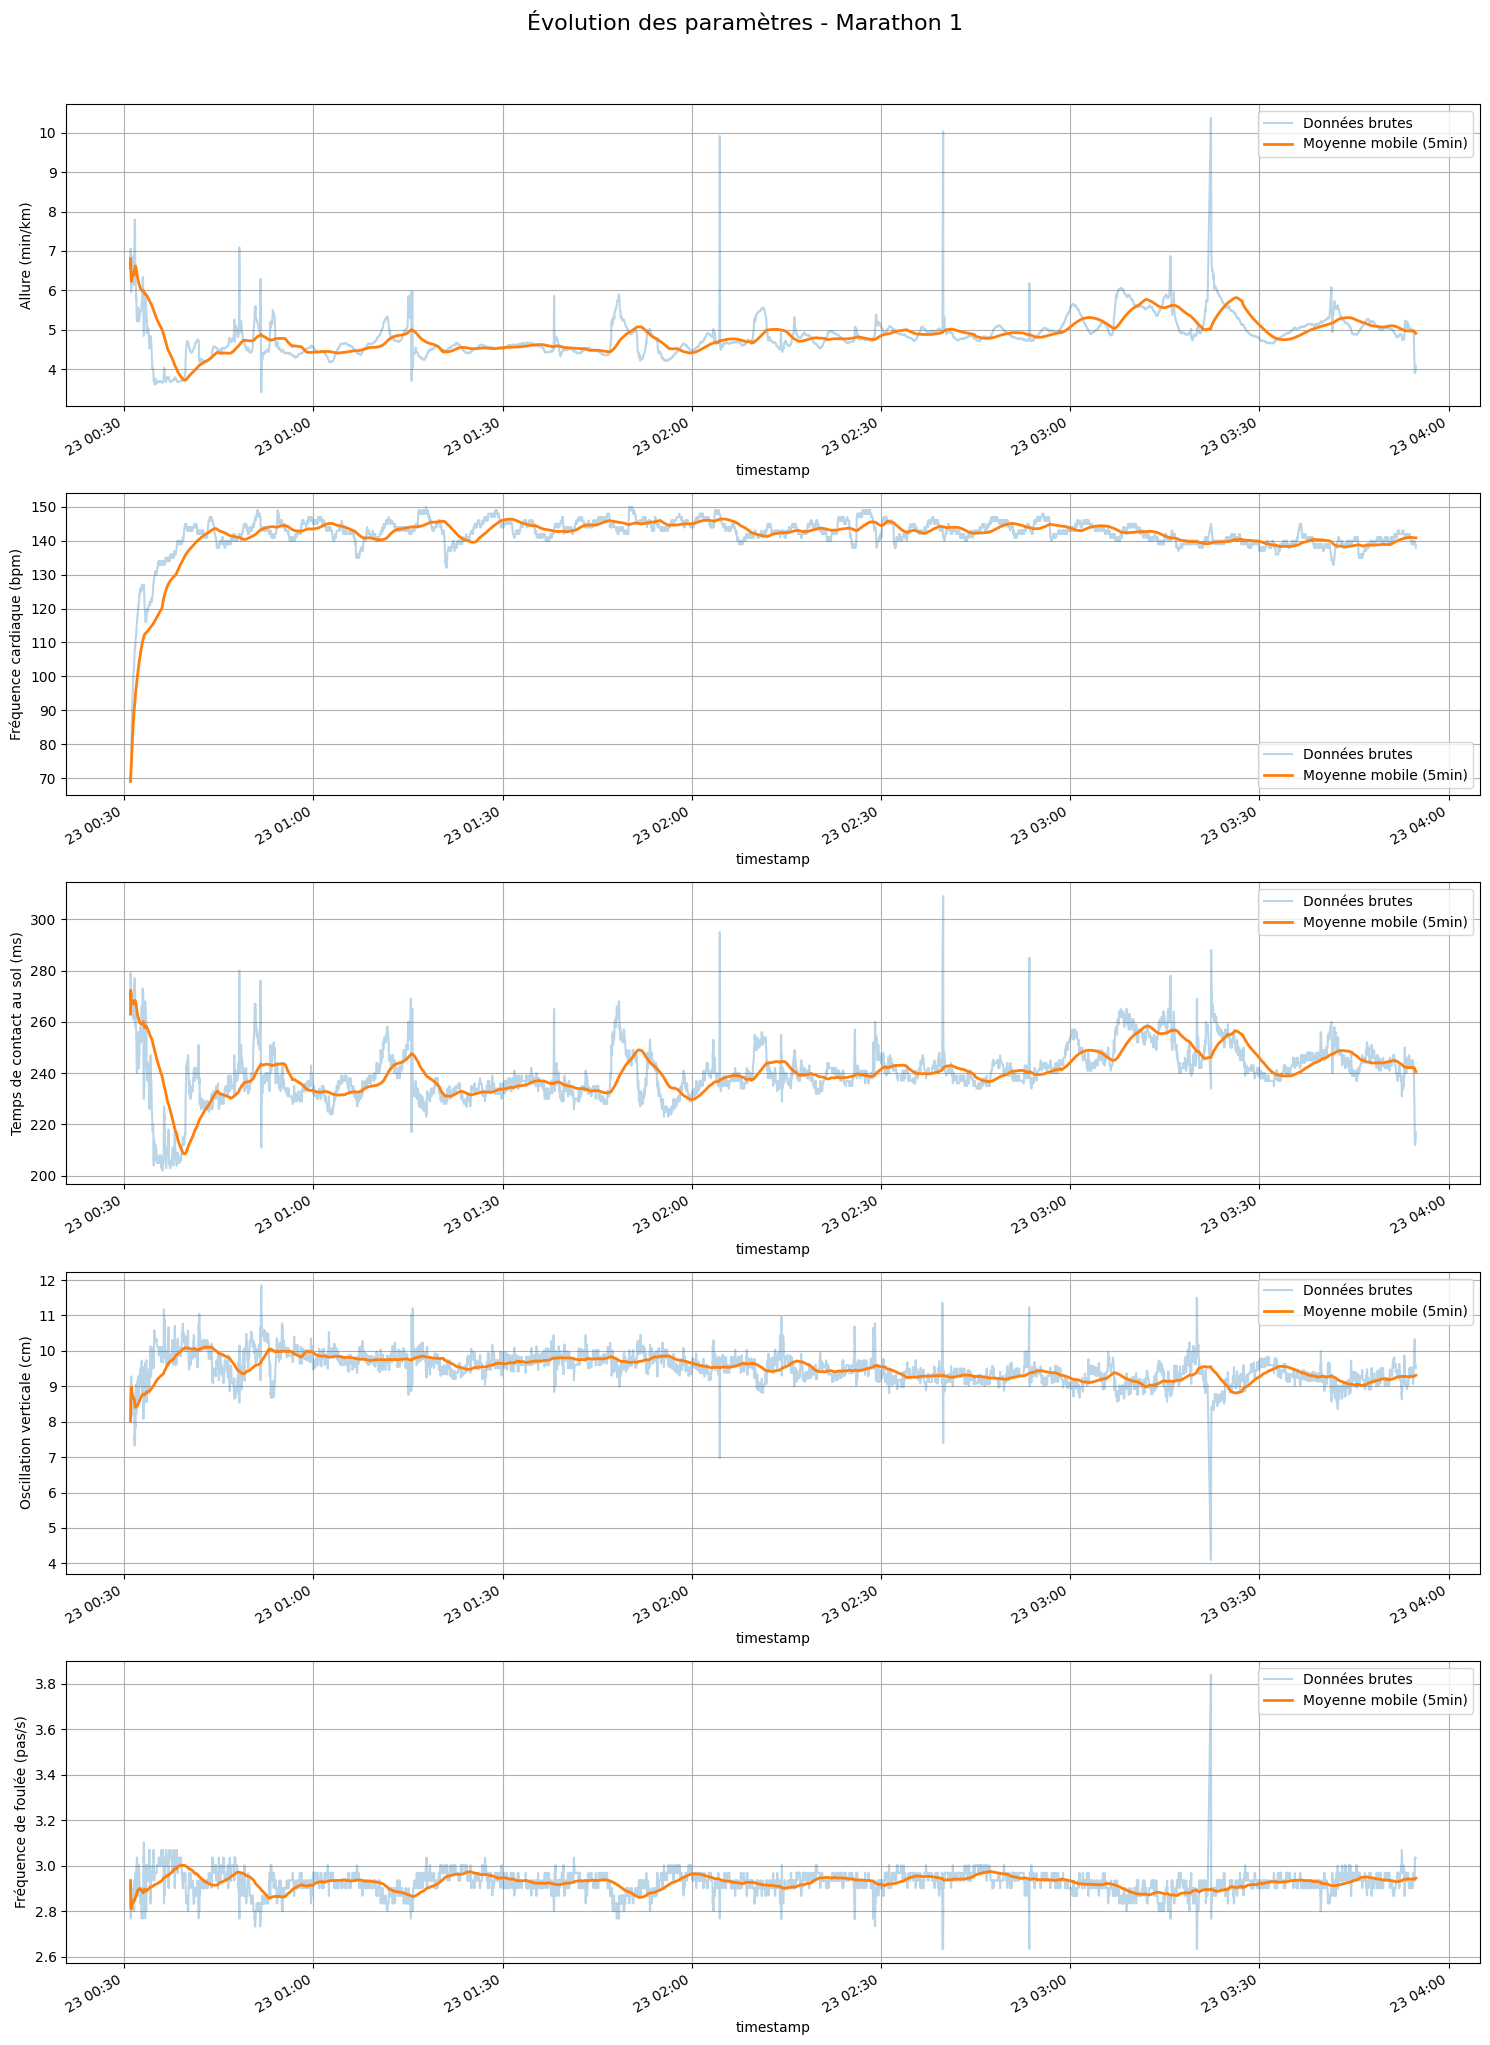

In [26]:
def plot_temporal_evolution(ts, course_name, window='5min'):
    """
    Trace l'évolution temporelle des paramètres clés avec moyenne mobile
    """
    params = {
        'pace': 'Allure (min/km)',
        'heart_rate': 'Fréquence cardiaque (bpm)',
        'stance_time': 'Temps de contact au sol (ms)',
        'vertical_oscillation': 'Oscillation verticale (cm)',
        'stride_frequency': 'Fréquence de foulée (pas/s)'
    }
    
    fig, axes = plt.subplots(len(params), 1, figsize=(15, 4*len(params)))
    fig.suptitle(f'Évolution des paramètres - {course_name}', y=1.02, size=16)
    
    for (param, title), ax in zip(params.items(), axes):
        # Données brutes
        ts[param].plot(alpha=0.3, label='Données brutes', ax=ax)
        # Moyenne mobile
        ts[param].rolling(window=window).mean().plot(
            linewidth=2, label=f'Moyenne mobile ({window})', ax=ax)
        
        ax.set_ylabel(title)
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Exemple sur le Marathon 1
plot_temporal_evolution(time_series['Marathon 1'], 'Marathon 1')

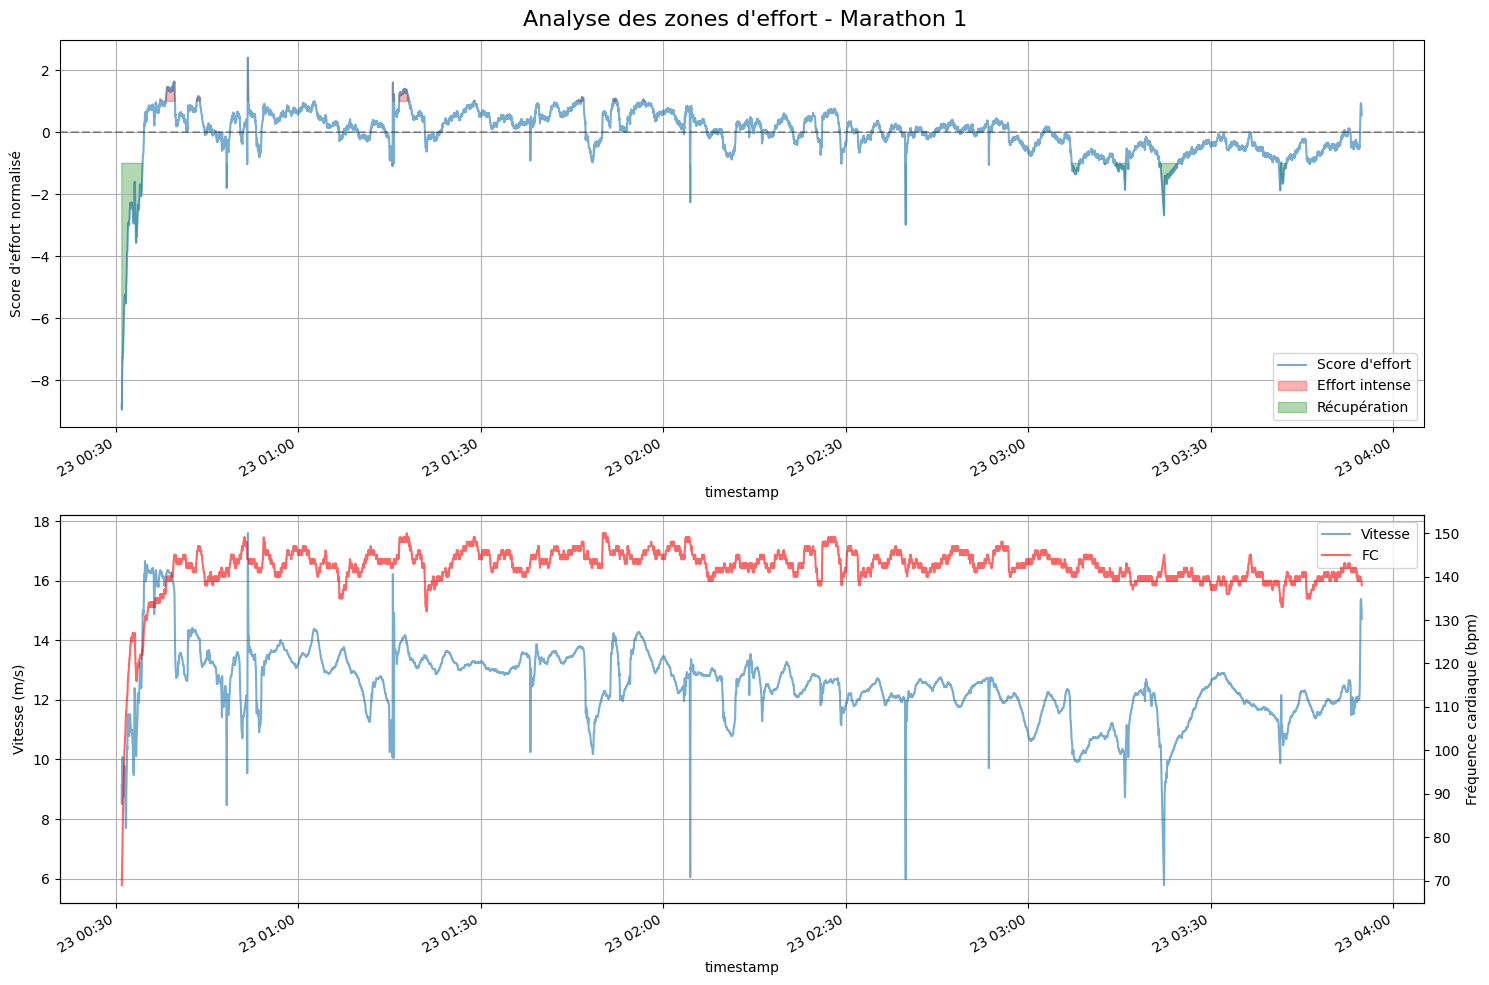


📊 Statistiques des zones d'effort
                Durée (min)  Pourcentage
Effort intense         5.65         2.79
Récupération          10.47         5.18


In [27]:
# Détection des zones d'effort
def detect_effort_zones(ts, course_name):
    """
    Détecte les zones d'effort basées sur la fréquence cardiaque et la vitesse
    """
    # Normalisation des paramètres
    hr_zscore = (ts['heart_rate'] - ts['heart_rate'].mean()) / ts['heart_rate'].std()
    speed_zscore = (ts['enhanced_speed'] - ts['enhanced_speed'].mean()) / ts['enhanced_speed'].std()
    
    # Score d'effort combiné
    effort_score = (hr_zscore + speed_zscore) / 2
    
    # Définition des seuils
    high_effort = effort_score > 1.0
    low_effort = effort_score < -1.0
    
    # Visualisation
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle(f'Analyse des zones d\'effort - {course_name}', size=16)
    
    # Premier graphique : Score d'effort
    effort_score.plot(ax=ax1, alpha=0.6, label='Score d\'effort')
    ax1.fill_between(effort_score.index, effort_score.where(high_effort), 1.0,
                     color='red', alpha=0.3, label='Effort intense')
    ax1.fill_between(effort_score.index, effort_score.where(low_effort), -1.0,
                     color='green', alpha=0.3, label='Récupération')
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax1.set_ylabel('Score d\'effort normalisé')
    ax1.legend()
    ax1.grid(True)
    
    # Second graphique : Paramètres physiques
    ts['enhanced_speed'].plot(ax=ax2, label='Vitesse', alpha=0.6)
    ax2_hr = ax2.twinx()
    ts['heart_rate'].plot(ax=ax2_hr, color='red', label='FC', alpha=0.6)
    
    ax2.set_ylabel('Vitesse (m/s)')
    ax2_hr.set_ylabel('Fréquence cardiaque (bpm)')
    
    # Combine legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_hr.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    ax2.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Statistiques sur les zones
    stats = pd.DataFrame({
        'Durée (min)': [high_effort.sum() / 60, low_effort.sum() / 60],
        'Pourcentage': [high_effort.mean() * 100, low_effort.mean() * 100]
    }, index=['Effort intense', 'Récupération'])
    
    print("\n📊 Statistiques des zones d'effort")
    print(stats.round(2))
    
    return stats

# Analyse du Marathon 1
effort_stats = detect_effort_zones(time_series['Marathon 1'], 'Marathon 1')

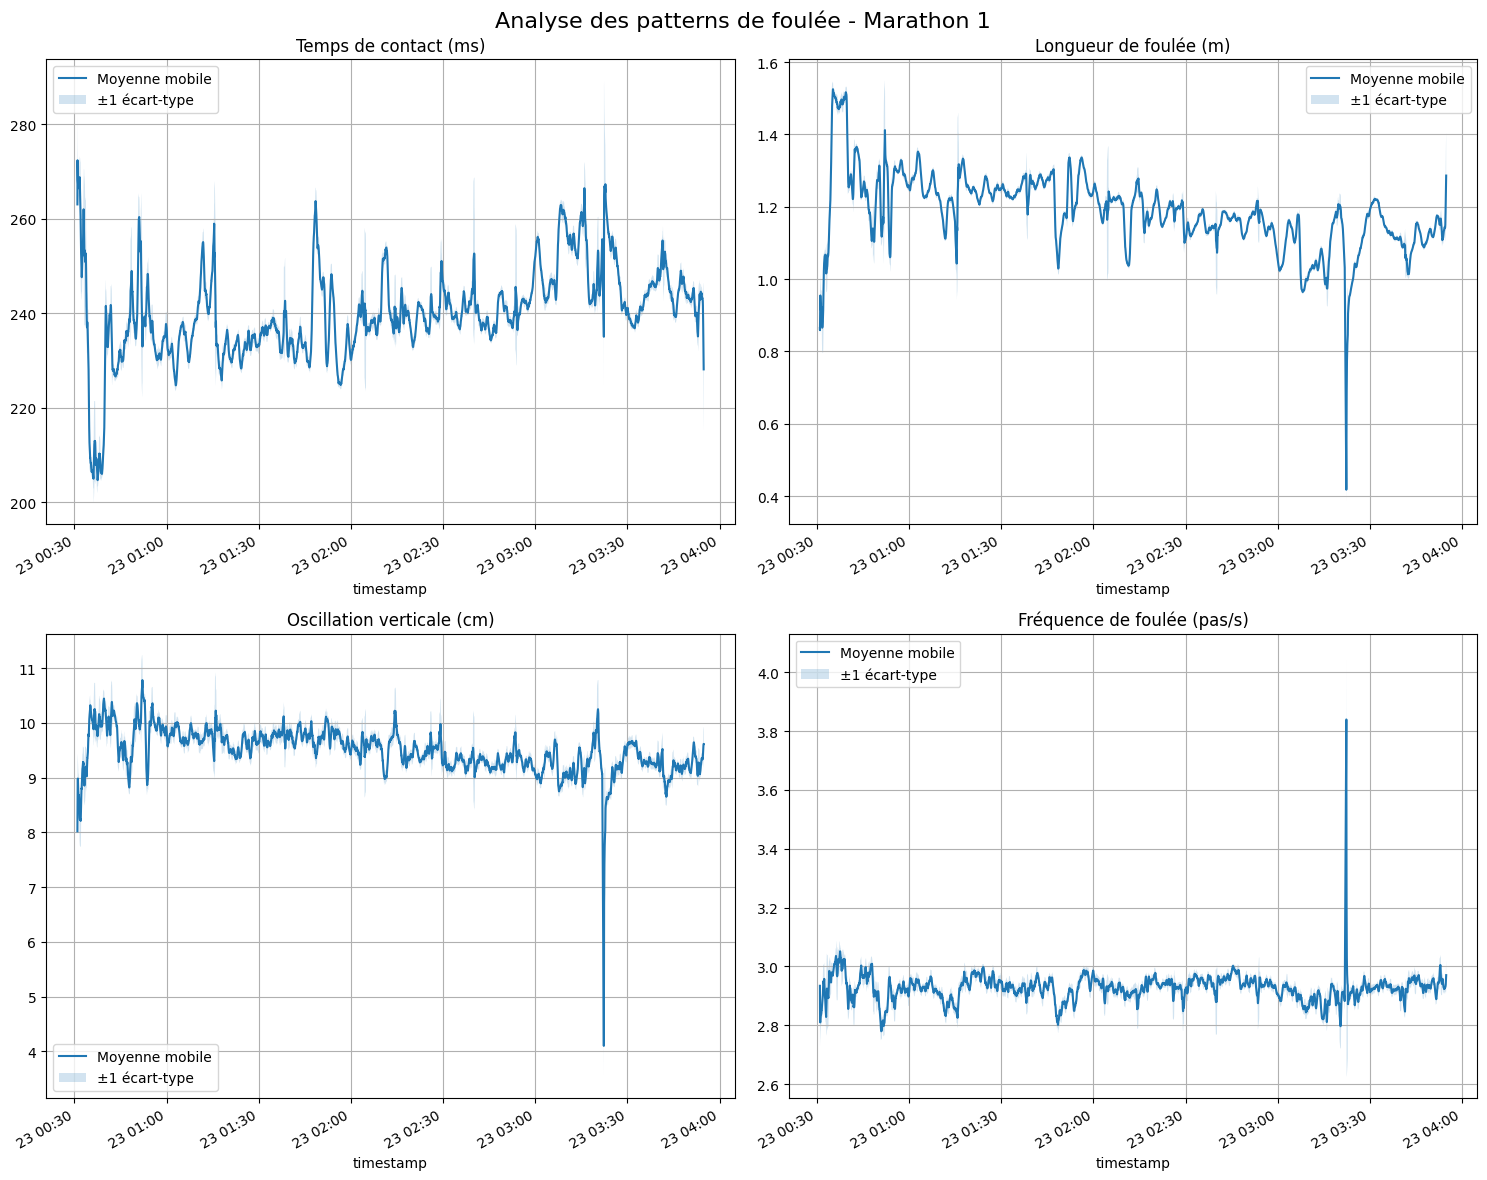


📊 Statistiques des patterns de foulée
       stance_time  step_length  vertical_oscillation  stride_frequency
count    12131.000    12131.000             12131.000         12131.000
mean       240.030        1.188                 9.506             2.926
std          9.931        0.102                 0.400             0.048
min        202.000        0.418                 4.100             2.633
25%        235.000        1.132                 9.240             2.901
50%        239.000        1.188                 9.500             2.934
75%        245.000        1.248                 9.770             2.967
max        309.000        1.746                11.850             3.840


In [28]:
# Analyse des cycles de foulée
from scipy.signal import find_peaks

def analyze_stride_patterns(ts, course_name, window='30s'):
    """
    Analyse les patterns de foulée et leur variabilité
    """
    # Calcul des métriques dérivées
    stride_metrics = pd.DataFrame({
        'stance_time': ts['stance_time'],
        'step_length': ts['step_length'],
        'vertical_oscillation': ts['vertical_oscillation'],
        'stride_frequency': ts['stride_frequency']
    })
    
    # Calcul des statistiques glissantes
    rolling_stats = stride_metrics.rolling(window=window).agg(['mean', 'std'])
    
    # Visualisation
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Analyse des patterns de foulée - {course_name}', size=16)
    
    metrics = list(stride_metrics.columns)
    titles = ['Temps de contact (ms)', 'Longueur de foulée (m)', 
             'Oscillation verticale (cm)', 'Fréquence de foulée (pas/s)']
    
    for (metric, title), ax in zip(zip(metrics, titles), axes.flat):
        # Données et moyenne mobile
        rolling_stats[metric]['mean'].plot(ax=ax, label='Moyenne mobile')
        
        # Intervalle de confiance
        ax.fill_between(rolling_stats.index,
                       rolling_stats[metric]['mean'] - rolling_stats[metric]['std'],
                       rolling_stats[metric]['mean'] + rolling_stats[metric]['std'],
                       alpha=0.2, label='±1 écart-type')
        
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques globales
    print("\n📊 Statistiques des patterns de foulée")
    stats = stride_metrics.describe()
    print(stats.round(3))
    
    return stats

# Analyse du Marathon 1
stride_stats = analyze_stride_patterns(time_series['Marathon 1'], 'Marathon 1')

C:\Users\mathi\AppData\Local\Temp\ipykernel_13228\4264422724.py:13: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled = ts.resample('30S').agg({



📊 Performance du modèle de prévision (enhanced_speed)
Données agrégées par 30 secondes sur 10 minutes d'historique
Nombre total d'échantillons d'entraînement : 309
R² sur l'entraînement : 0.961
R² sur le test : 0.864
RMSE sur le test : 0.342 m/s

📊 Statistiques des vitesses dans les données:
count    408.000000
mean      12.510475
std        1.125910
min        8.003167
25%       11.933783
50%       12.541433
75%       13.193450
max       16.320500
Name: enhanced_speed, dtype: float64


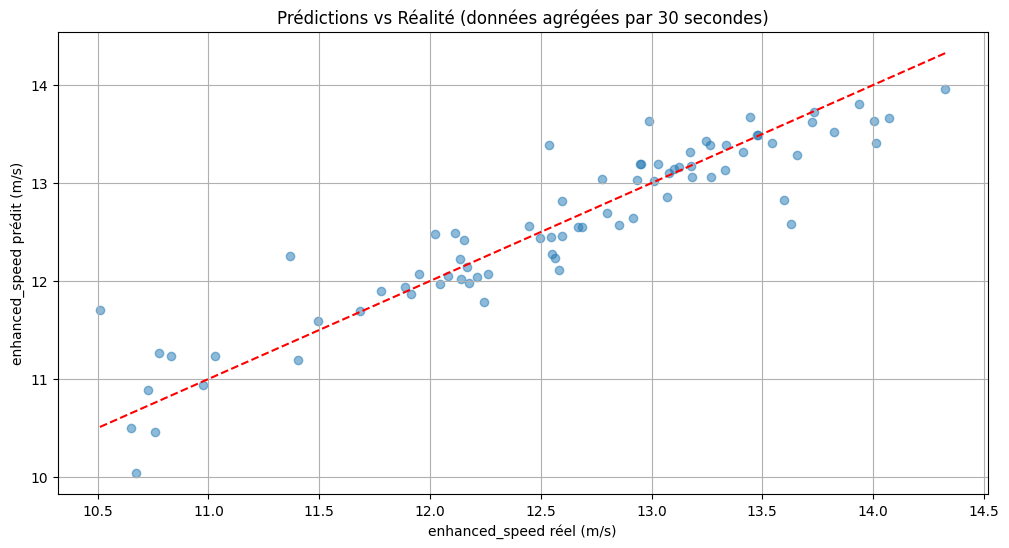


🔍 Top 10 variables les plus importantes :
                   Feature  Importance
119              pace_t-19    0.438298
117              pace_t-17    0.337114
115              pace_t-15    0.053835
86   enhanced_altitude_t-6    0.007155
116              pace_t-16    0.005460
104               pace_t-4    0.003686
32        stance_time_t-12    0.003331
33        stance_time_t-13    0.003281
111              pace_t-11    0.003149
113              pace_t-13    0.002935


In [29]:
# Prévision des performances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np

def predict_performance(ts, target='enhanced_speed', history_minutes=10):
    """
    Crée un modèle de prévision des performances basé sur l'historique récent
    avec agrégation par 30 secondes pour réduire le bruit
    """
    # Agrégation par 30 secondes
    resampled = ts.resample('30S').agg({
        'heart_rate': 'mean',
        'stance_time': 'mean',
        'vertical_oscillation': 'mean',
        'step_length': 'mean',
        'enhanced_speed': 'mean',
        'enhanced_altitude': 'mean',
        'pace': 'mean'
    }).dropna()
    
    # Préparation des features
    features = ['heart_rate', 'stance_time', 'vertical_oscillation', 
               'step_length', 'enhanced_altitude', 'pace']
    
    # Création des features avec historique
    X = []
    y = []
    
    # Convertir history_minutes en nombre de périodes de 30 secondes
    history_periods = history_minutes * 2
    
    data = resampled[features + [target]].values
    for i in range(history_periods, len(data) - 1):
        X.append(data[i-history_periods:i, :-1].flatten())  # historique des features
        y.append(data[i, -1])  # vitesse suivante
        
    X = np.array(X)
    y = np.array(y)
    
    if len(X) == 0:
        raise ValueError("Pas assez de données pour l'entraînement après agrégation")
    
    # Split des données
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Entraînement du modèle avec paramètres ajustés
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    
    # Évaluation
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    
    print(f"\n📊 Performance du modèle de prévision ({target})")
    print(f"Données agrégées par 30 secondes sur {history_minutes} minutes d'historique")
    print(f"Nombre total d'échantillons d'entraînement : {len(X_train)}")
    print(f"R² sur l'entraînement : {train_score:.3f}")
    print(f"R² sur le test : {test_score:.3f}")
    
    # RMSE pour avoir une idée de l'erreur en m/s
    rmse_test = np.sqrt(np.mean((model.predict(X_test_scaled) - y_test) ** 2))
    print(f"RMSE sur le test : {rmse_test:.3f} m/s")
    
    # Statistiques des vitesses réelles pour validation
    print("\n📊 Statistiques des vitesses dans les données:")
    speed_stats = resampled['enhanced_speed'].describe()
    print(speed_stats)
    
    # Feature importance
    importance = pd.DataFrame({
        'Feature': [f"{feat}_t-{i}" for feat in features for i in range(history_periods)],
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Visualisation des prédictions
    y_pred = model.predict(X_test_scaled)
    
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel(f'{target} réel (m/s)')
    plt.ylabel(f'{target} prédit (m/s)')
    plt.title('Prédictions vs Réalité (données agrégées par 30 secondes)')
    plt.grid(True)
    plt.show()
    
    # Top 10 features les plus importantes
    print("\n🔍 Top 10 variables les plus importantes :")
    print(importance.head(10))
    
    return model, scaler, importance, resampled

# Prévision sur le Marathon 1 avec 10 minutes d'historique
model, scaler, importance, resampled_data = predict_performance(time_series['Marathon 1'], history_minutes=10)

# 🎯 Conclusion et Insights

L'analyse biomécanique réalisée ci-dessus nous permet de tirer plusieurs enseignements :

1. **Évolution temporelle** : Visualisation de l'évolution des paramètres clés au cours de la course avec des moyennes mobiles pour identifier les tendances.

2. **Zones d'effort** : Identification des périodes d'effort intense et de récupération basées sur la combinaison de la fréquence cardiaque et de la vitesse.

3. **Patterns de foulée** : Analyse de la variabilité des paramètres de foulée (temps de contact, longueur, oscillation verticale) pour comprendre l'adaptation du style de course.

4. **Prévisions** : Modèle prédictif pour anticiper les performances futures basé sur l'historique récent des paramètres biomécaniques.

Ces analyses peuvent servir à :
- Optimiser la stratégie de course
- Identifier les zones de fatigue
- Améliorer la technique de course
- Prévoir et prévenir les baisses de performance

In [30]:
def predict_future_performance(ts, model, scaler, distance_km=None, minutes=None):
    """
    Prédit les performances futures sur une distance ou une durée donnée
    en utilisant les données agrégées par 30 secondes
    """
    # Agrégation par 30 secondes des dernières données
    last_data = ts.resample('30S').agg({
        'heart_rate': 'mean',
        'stance_time': 'mean',
        'vertical_oscillation': 'mean',
        'step_length': 'mean',
        'enhanced_altitude': 'mean',
        'pace': 'mean'
    }).dropna()
    
    features = ['heart_rate', 'stance_time', 'vertical_oscillation', 
                'step_length', 'enhanced_altitude', 'pace']
    
    # Prendre les 10 dernières périodes de 30 secondes comme contexte
    recent_data = last_data[features].iloc[-20:].values.flatten()
    
    # Mise à l'échelle des données
    X_pred = scaler.transform(recent_data.reshape(1, -1))
    
    # Prédiction de la vitesse (en km/h)
    predicted_speed = model.predict(X_pred)[0]
    
    # Contraintes sur la vitesse prédite basées sur les statistiques historiques
    speed_stats = ts['enhanced_speed'].describe()
    min_speed = speed_stats['25%']  # 25ème percentile
    max_speed = speed_stats['75%']  # 75ème percentile
    
    # Application des contraintes
    predicted_speed = np.clip(predicted_speed, min_speed, max_speed)
    
    # Calculs des métriques
    pace = 60 / predicted_speed  # min/km (vitesse en km/h)
    
    if distance_km:
        estimated_time = pace * distance_km  # minutes totales
        hours = int(estimated_time // 60)
        minutes_part = int(estimated_time % 60)
        seconds = int((estimated_time * 60) % 60)
        
        print(f"\n🎯 Prédiction pour les prochains {distance_km} km:")
        print(f"Vitesse moyenne prédite: {predicted_speed:.2f} km/h ({pace:.2f} min/km)")
        print(f"Temps estimé: {hours:02d}:{minutes_part:02d}:{seconds:02d}")
        
    if minutes:
        distance = (predicted_speed * minutes) / 60  # distance en km (vitesse en km/h)
        
        print(f"\n🎯 Prédiction pour les prochaines {minutes} minutes:")
        print(f"Vitesse moyenne prédite: {predicted_speed:.2f} km/h ({pace:.2f} min/km)")
        print(f"Distance estimée: {distance:.2f} km")

    # Afficher le contexte et les statistiques
    print("\n📊 Contexte de la prédiction:")
    print(f"Vitesse moyenne historique: {ts['enhanced_speed'].mean():.2f} km/h")
    print(f"Vitesse minimale acceptable: {min_speed:.2f} km/h")
    print(f"Vitesse maximale acceptable: {max_speed:.2f} km/h")
    print("\n📊 Moyennes des 5 dernières minutes utilisées:")
    for feat in features:
        print(f"{feat}: {last_data[feat].iloc[-10:].mean():.2f}")

# Prédictions pour le Marathon 1
print("📊 Prédictions basées sur les dernières données du Marathon 1 (agrégées par 30 secondes):")
predict_future_performance(time_series['Marathon 1'], model, scaler, distance_km=3)
predict_future_performance(time_series['Marathon 1'], model, scaler, minutes=15)

📊 Prédictions basées sur les dernières données du Marathon 1 (agrégées par 30 secondes):

🎯 Prédiction pour les prochains 3 km:
Vitesse moyenne prédite: 13.20 km/h (4.55 min/km)
Temps estimé: 00:13:38

📊 Contexte de la prédiction:
Vitesse moyenne historique: 12.52 km/h
Vitesse minimale acceptable: 11.92 km/h
Vitesse maximale acceptable: 13.20 km/h

📊 Moyennes des 5 dernières minutes utilisées:
heart_rate: 140.83
stance_time: 239.76
vertical_oscillation: 9.34
step_length: 1.17
enhanced_altitude: 188.82
pace: 4.87

🎯 Prédiction pour les prochaines 15 minutes:
Vitesse moyenne prédite: 13.20 km/h (4.55 min/km)
Distance estimée: 3.30 km

📊 Contexte de la prédiction:
Vitesse moyenne historique: 12.52 km/h
Vitesse minimale acceptable: 11.92 km/h
Vitesse maximale acceptable: 13.20 km/h

📊 Moyennes des 5 dernières minutes utilisées:
heart_rate: 140.83
stance_time: 239.76
vertical_oscillation: 9.34
step_length: 1.17
enhanced_altitude: 188.82
pace: 4.87


C:\Users\mathi\AppData\Local\Temp\ipykernel_13228\99844025.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  last_data = ts.resample('30S').agg({
C:\Users\mathi\AppData\Local\Temp\ipykernel_13228\99844025.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  last_data = ts.resample('30S').agg({


# 🎮 Simulation de Performance

Cette section permet de simuler une course en définissant des paramètres biomécaniques (fréquence cardiaque, temps de contact au sol, etc.) pour prédire la vitesse et le temps sur une distance donnée.

In [ ]:
def simulate_performance(model, scaler, distance_km, 
                      heart_rate=150, stance_time=250, 
                      vertical_oscillation=8, step_length=1.2,
                      enhanced_altitude=0, simulated_pace=5):
    """
    Simule une performance sur une distance donnée avec des paramètres biomécaniques définis
    
    Paramètres:
    - heart_rate: Fréquence cardiaque (bpm)
    - stance_time: Temps de contact au sol (ms)
    - vertical_oscillation: Oscillation verticale (cm)
    - step_length: Longueur de foulée (m)
    - enhanced_altitude: Altitude (m)
    - simulated_pace: Allure estimée (min/km)
    """
    # Création d'un jeu de données simulé
    simulated_data = np.array([
        heart_rate, stance_time, vertical_oscillation,
        step_length, enhanced_altitude, simulated_pace
    ])
    
    # Répétition des données pour correspondre à l'historique attendu (10 minutes)
    simulated_history = np.tile(simulated_data, 20)  # 20 périodes de 30 secondes
    
    # Mise à l'échelle des données
    X_sim = scaler.transform(simulated_history.reshape(1, -1))
    
    # Prédiction de la vitesse
    predicted_speed = model.predict(X_sim)[0]
    
    # Calcul des métriques
    pace = 60 / predicted_speed  # min/km
    total_time = pace * distance_km  # minutes totales
    
    # Conversion du temps en heures, minutes, secondes
    hours = int(total_time // 60)
    minutes = int(total_time % 60)
    seconds = int((total_time * 60) % 60)
    
    # Affichage des résultats
    print(f"\n🎯 Simulation pour {distance_km} km avec les paramètres suivants:")
    print(f"  • Fréquence cardiaque : {heart_rate} bpm")
    print(f"  • Temps de contact : {stance_time} ms")
    print(f"  • Oscillation verticale : {vertical_oscillation} cm")
    print(f"  • Longueur de foulée : {step_length} m")
    print(f"  • Altitude : {enhanced_altitude} m")
    print(f"  • Allure visée : {simulated_pace} min/km")
    
    print(f"\n📊 Résultats de la simulation:")
    print(f"  • Vitesse prédite : {predicted_speed:.2f} km/h")
    print(f"  • Allure prédite : {pace:.2f} min/km")
    print(f"  • Temps estimé : {hours:02d}:{minutes:02d}:{seconds:02d}")
    
    return predicted_speed, pace, total_time

# Exemple de simulations
print("🏃 Simulation d'un semi-marathon (21.1 km)")
print("==========================================")

# Simulation pour un rythme modéré
simulate_performance(model, scaler, 21.1,
                    heart_rate=155,
                    stance_time=240,
                    vertical_oscillation=8.5,
                    step_length=1.25,
                    simulated_pace=5.30)

print("\n🏃 Simulation d'un 10 km")
print("==========================================")

# Simulation pour un rythme plus rapide
simulate_performance(model, scaler, 10,
                    heart_rate=165,
                    stance_time=220,
                    vertical_oscillation=9.0,
                    step_length=1.35,
                    simulated_pace=4.45)